# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
All FOVs

### Pre-requisites

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

In [5]:
nc.__version__

'0.1.5'

### Load data

In [6]:
folder = '/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/'
file   = 'S1_annotated_l0.h5ad' 
adata = sc.read(filename = folder + file)
adata

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [7]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

In [8]:
adata.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is 

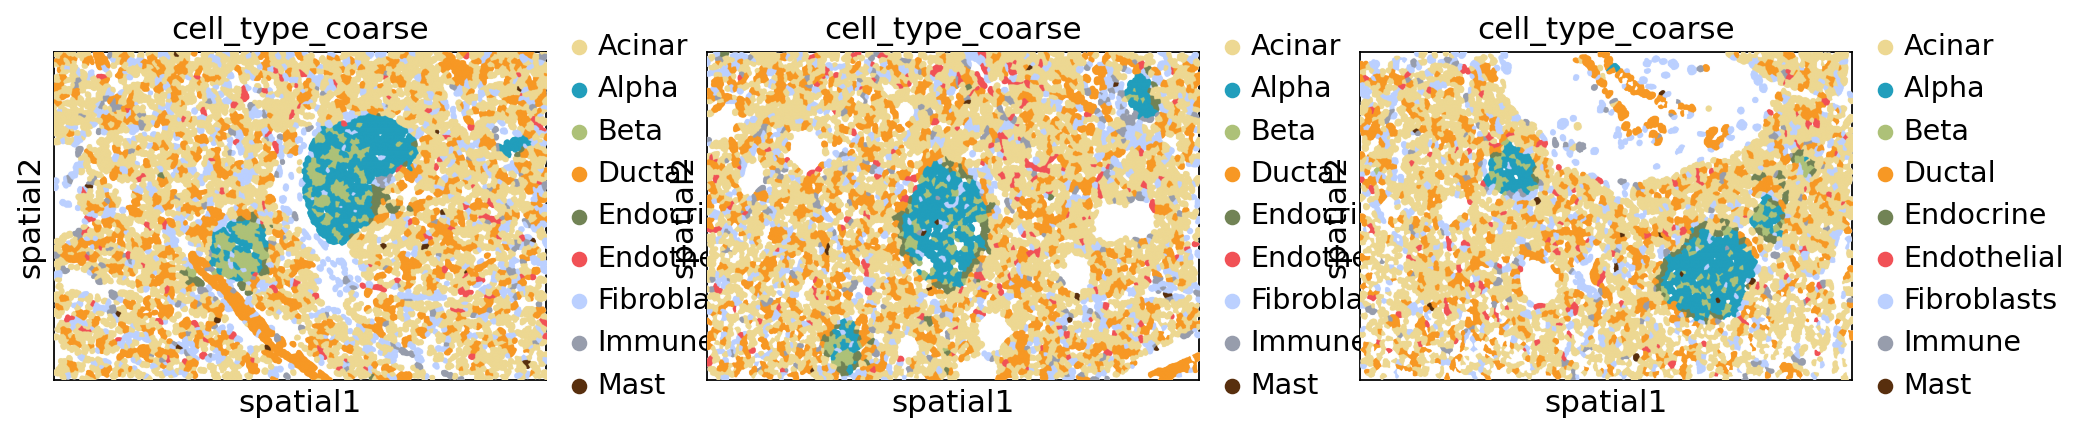

In [17]:
sq.pl.spatial_segment(adata,color='cell_type_coarse',
                      library_key='fov', library_id=['12','15','19'],
                      seg_cell_id='cell_ID', img=False)

In [ ]:
from matplotlib.pyplot import rc_context

In [ ]:
HORMONES = ['INS','GCG','SST']
adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

In [ ]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

In [23]:
adata.X = adata.X.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar
Alpha
Beta
Ductal
Endocrine
Endothelial
Fibroblasts
Immune
Mast


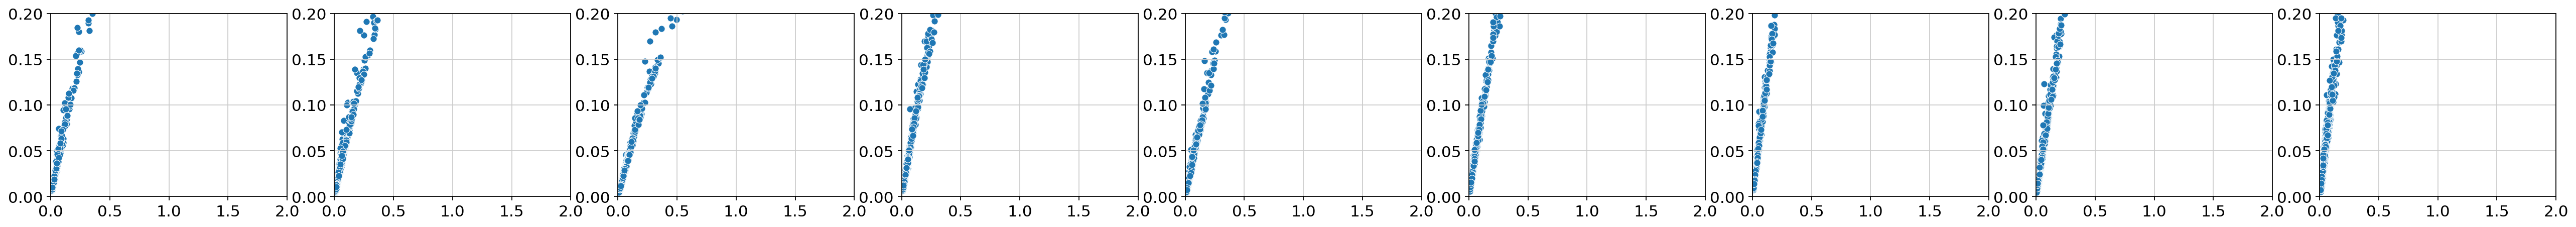

In [25]:
fig, ax = plt.subplots(1,len(np.unique(adata.obs['cell_type_coarse'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata.obs['cell_type_coarse'])):
    print(ct)
    mean = np.mean(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    var = np.var(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

In [26]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

### Pre-processing

In [27]:
# the data seems not normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.3794671 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.18072315,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [28]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

0.005151272640303189
20.45101231706083
42.15089549355631
205.6984665765194
545.0749970104222
3970.9061088574294


In [ ]:
sq.gr.spatial_neighbors

In [29]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=25,
    coord_type="generic",
    delaunay=True,
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:27: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


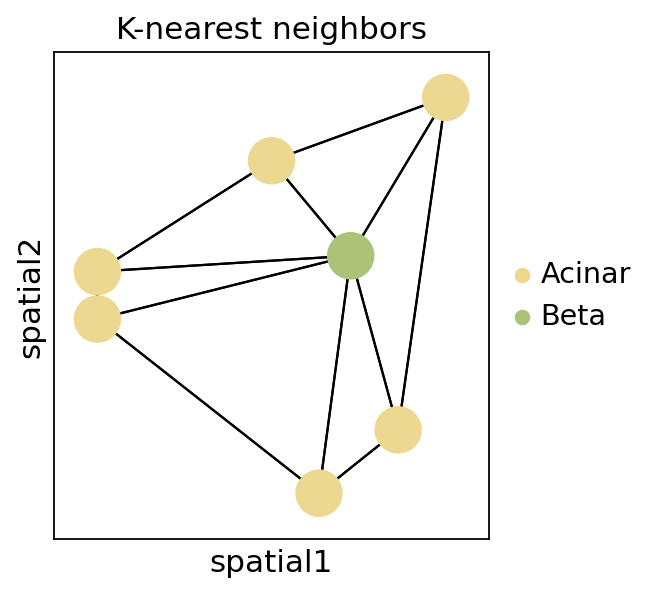

In [31]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '12',
    color="cell_type_coarse",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [32]:
sq.gr.nhood_enrichment(adata,cluster_key='cell_type_coarse')

100%|██████████| 1000/1000 [00:08<00:00, 112.63/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


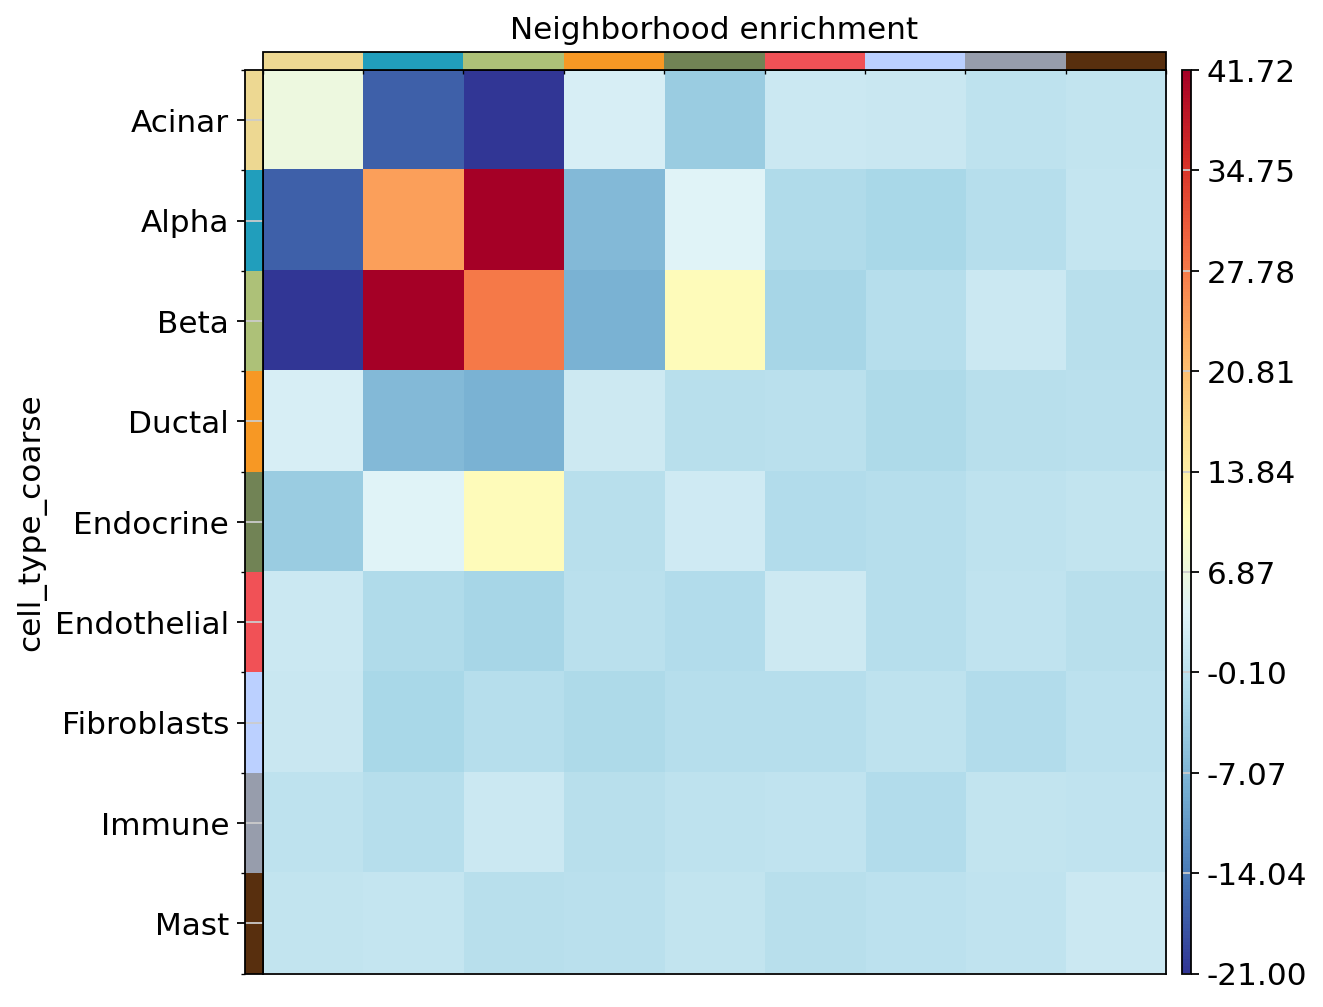

In [33]:
sq.pl.nhood_enrichment(adata, cluster_key='cell_type_coarse',cmap='RdYlBu_r',save='neig_enr.pdf')

In [34]:
sq.gr.interaction_matrix(adata, cluster_key='cell_type_coarse',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


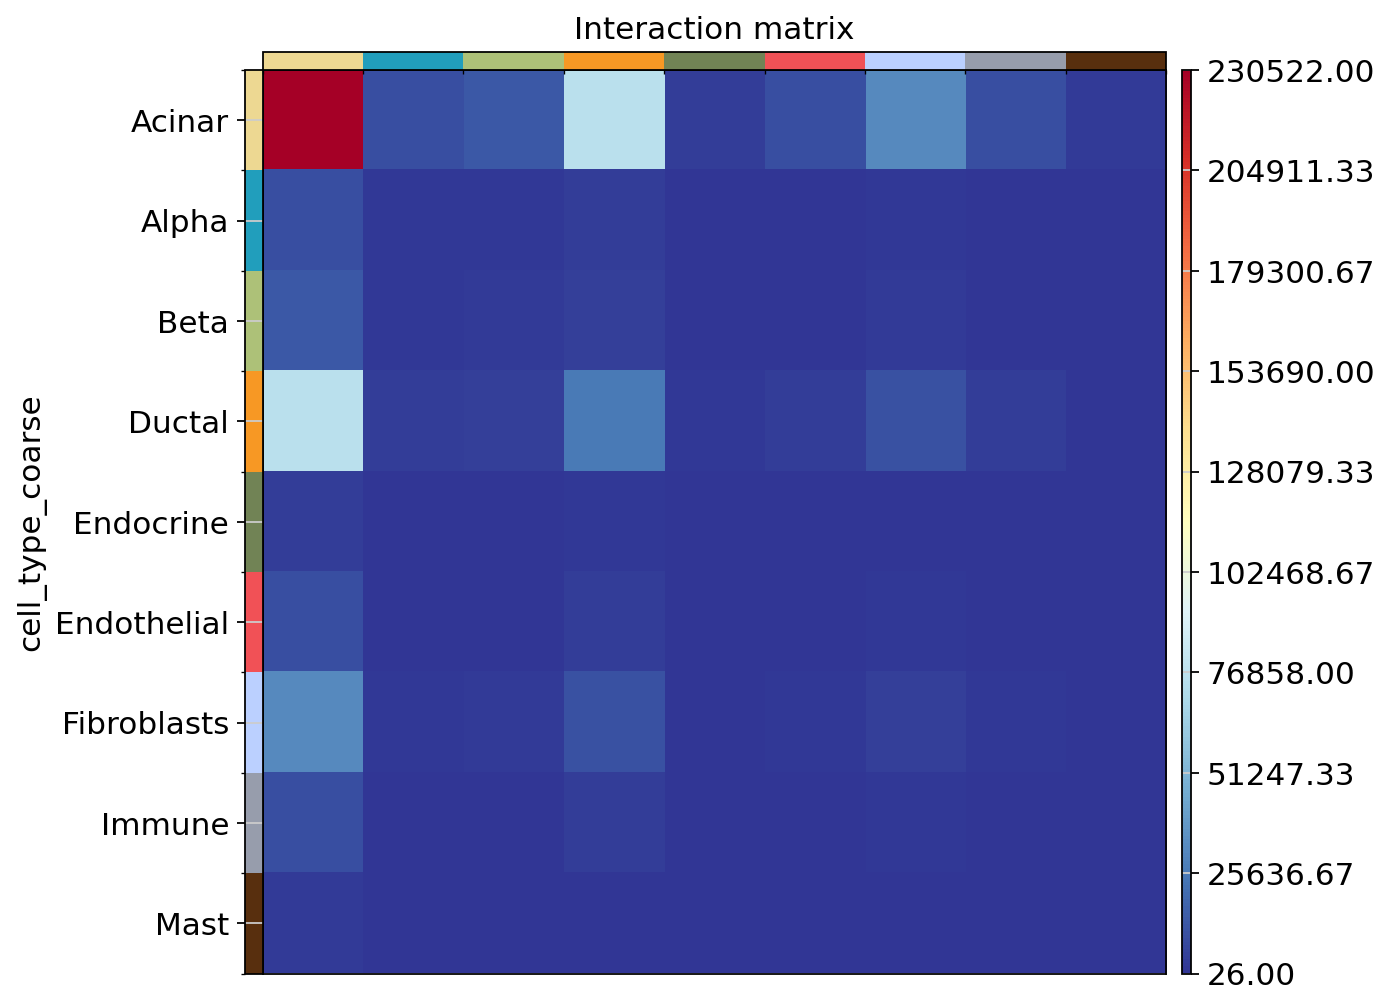

In [35]:
sq.pl.interaction_matrix(adata, cluster_key='cell_type_coarse',cmap='RdYlBu_r')

In [ ]:
sq.gr.ligrec(adata,cluster_key='cell_type',use_raw=False)

In [ ]:
sq.pl.ligrec(adata, cluster_key='cell_type',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [36]:
from ncem.tl.fit.glm import linear_ncem

In [ ]:
linear_ncem

In [37]:
adata_sp_fov_12 = adata[np.isin(adata.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'spatial_neighbors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 'spat

In [42]:
adata = linear_ncem(adata=adata_sp_fov_12, key_type='cell_type_coarse', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
adata.obs['cell_type'].cat.categories

In [ ]:
adata

### Exploring interesting interactions

In [39]:
interactions = [
    'index_Endocrine:neighbor_Ductal',
    'index_Ductal:neighbor_Endocrine',
    'index_Acinar:neighbor_Ductal',
    'index_Ductal:neighbor_Acinar',
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

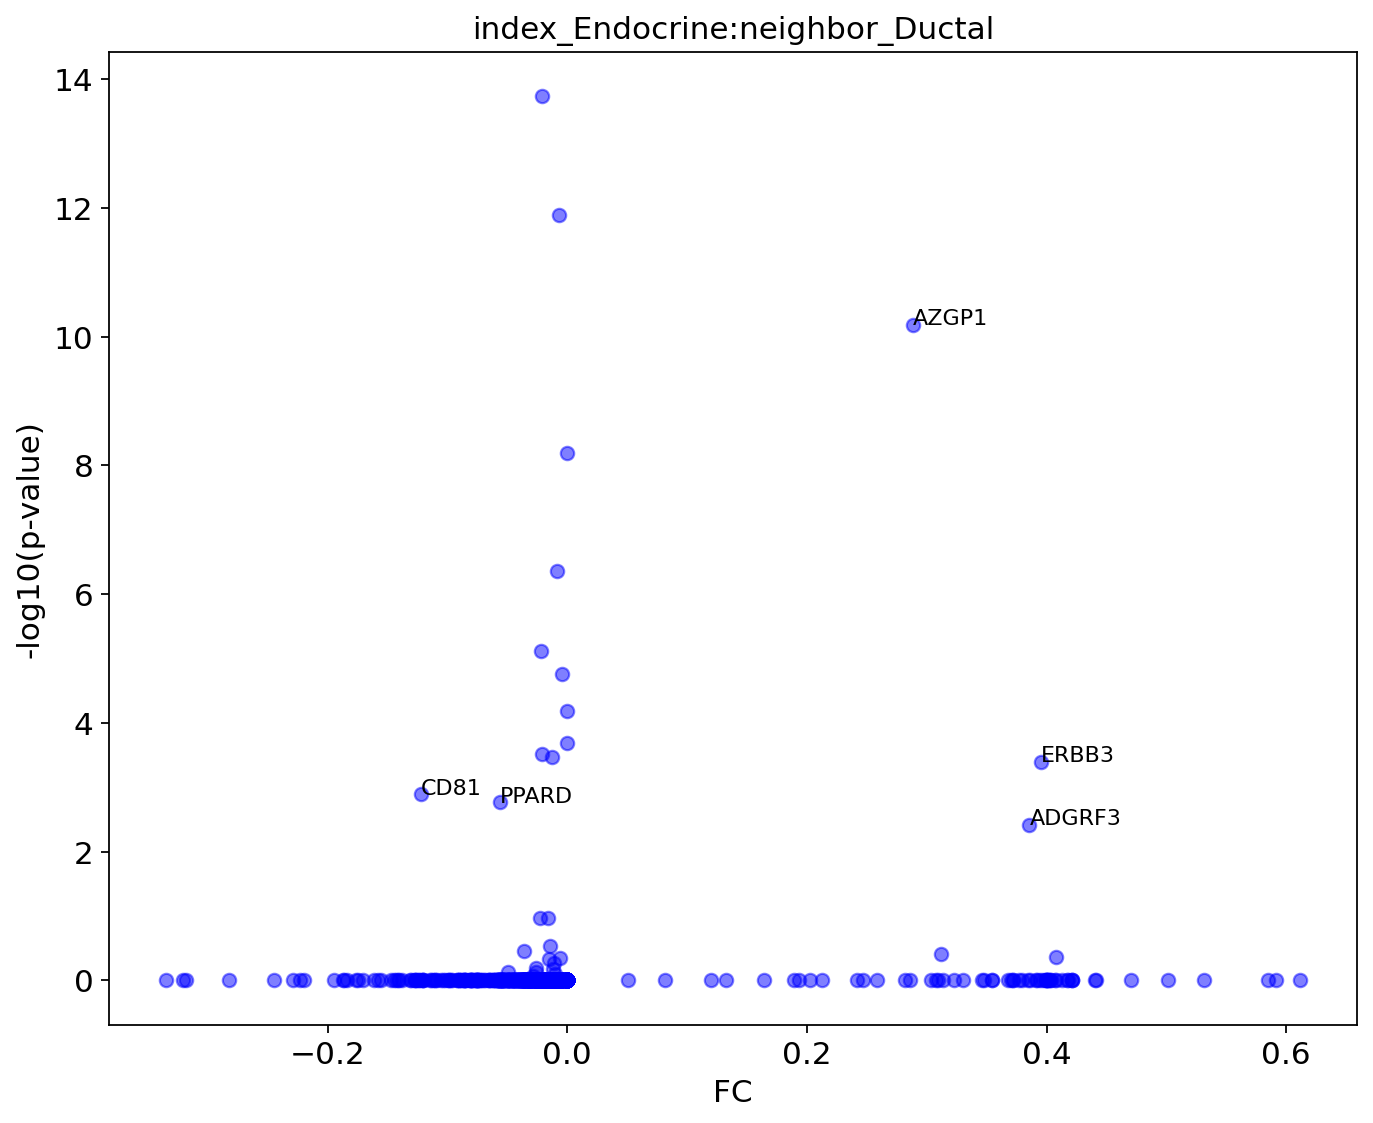

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

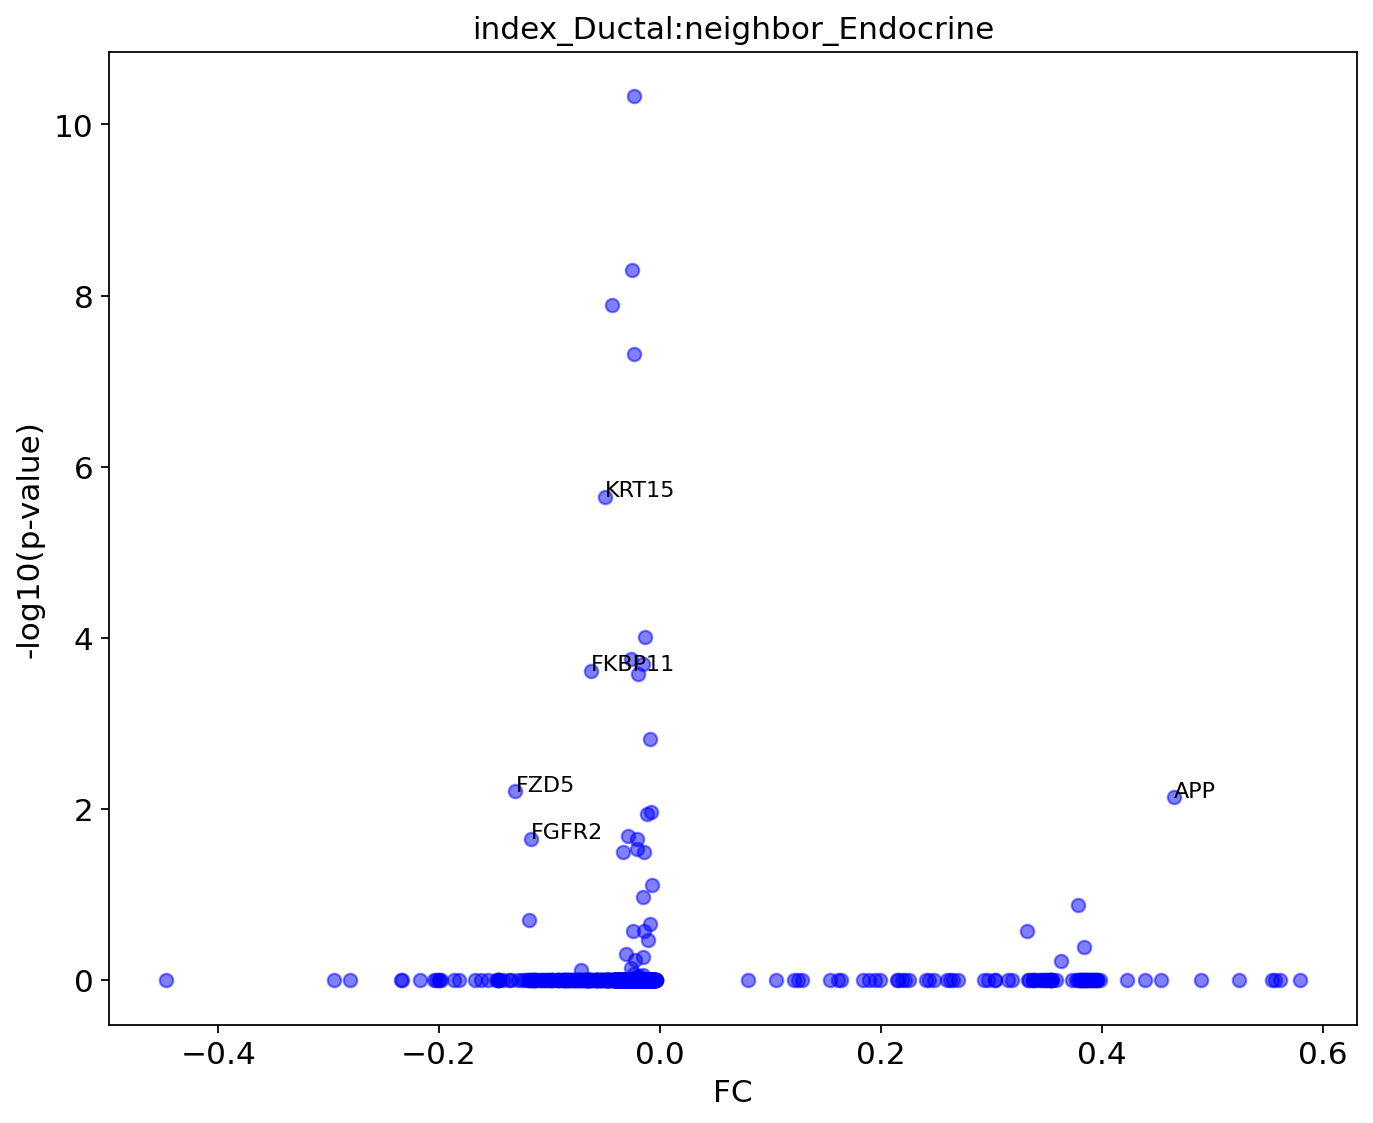

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

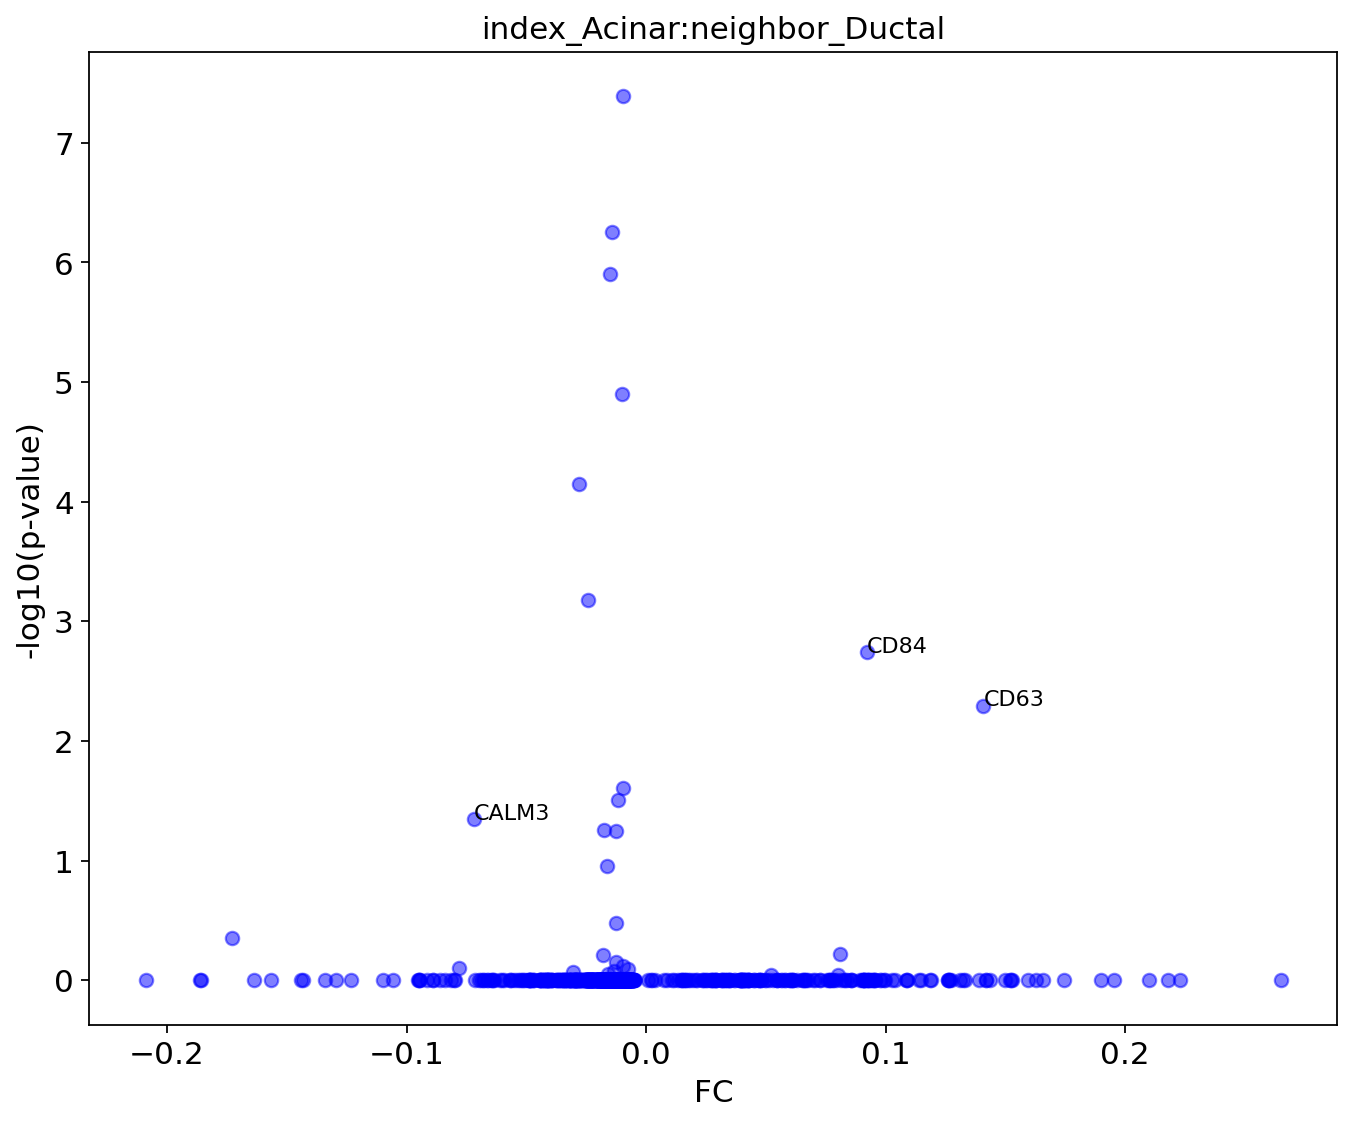

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

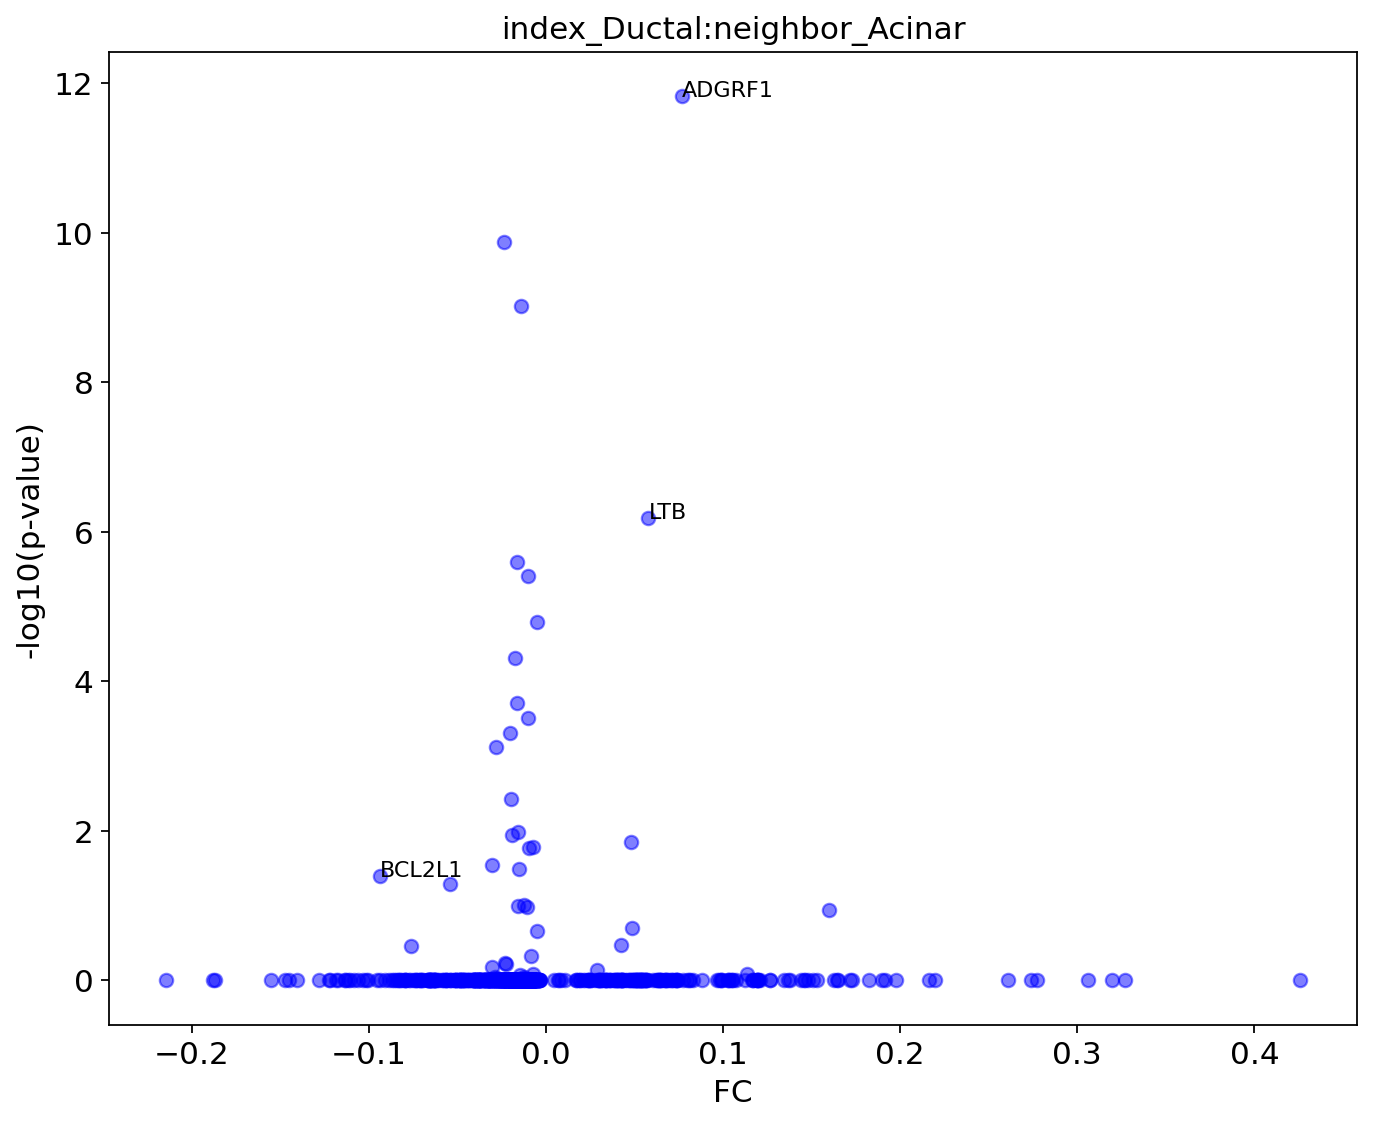

In [43]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata_sp_fov_12.varm['ncem_params'][c],
        'padj' : adata_sp_fov_12.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata_sp_fov_12.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [41]:
adata.varm['ncem_params']

,index_Acinar,index_Alpha,index_Beta,index_Ductal,index_Endocrine,index_Endothelial,index_Fibroblasts,index_Immune,index_Mast,index_Acinar:neighbor_Acinar,...,index_Mast:neighbor_Immune,index_Acinar:neighbor_Mast,index_Alpha:neighbor_Mast,index_Beta:neighbor_Mast,index_Ductal:neighbor_Mast,index_Endocrine:neighbor_Mast,index_Endothelial:neighbor_Mast,index_Fibroblasts:neighbor_Mast,index_Immune:neighbor_Mast,index_Mast:neighbor_Mast
AATK,0.024490,0.059645,0.057469,0.018066,0.047443,0.008745,0.001753,0.034043,-0.038757,0.003359,...,-0.008797,-0.000109,0.005324,-0.015027,-0.006813,-0.007275,0.035110,0.001306,0.002072,0.014883
ABL1,0.023130,0.054959,0.049712,0.025529,0.030751,0.028785,0.039216,-0.005534,-0.009489,-0.002738,...,0.008641,-0.002997,0.002861,0.004964,0.000409,-0.015515,-0.006640,-0.001787,0.009709,-0.021574
ABL2,0.103594,0.044593,0.027150,0.044204,-0.002331,0.163670,0.044124,0.102805,0.085918,-0.002351,...,-0.027472,-0.006001,-0.002237,0.010154,0.005402,0.057785,0.003557,-0.000834,-0.021554,0.008228
ACE,0.010672,0.015412,0.017369,0.010261,-0.002758,0.028118,0.023006,0.011261,0.008855,0.000125,...,-0.015099,0.002406,-0.007600,0.007809,-0.008590,0.004779,0.018478,0.007801,-0.001108,0.001812
ACE2,0.019125,0.046296,0.026911,0.010412,0.025252,0.029603,0.025518,0.047607,0.015728,-0.005309,...,0.009067,0.000292,0.003865,-0.010359,0.002018,-0.016699,0.022135,-0.006071,-0.000623,-0.001937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegPrb19,0.014721,0.013448,0.011972,0.005275,0.001650,0.001031,0.004197,0.002427,-0.036116,-0.000769,...,0.004580,0.000934,0.000089,-0.003532,0.003604,-0.011970,-0.007370,-0.007251,-0.000266,-0.010835
NegPrb20,0.023750,-0.001629,0.013194,0.017421,0.001438,0.015992,0.007909,0.017874,0.019757,-0.001917,...,0.014954,0.001192,-0.009955,-0.001898,-0.001577,-0.017551,-0.009816,-0.005406,-0.006127,0.016340
NegPrb21,0.008725,0.012298,0.009928,0.005791,0.007378,0.000100,0.012360,-0.001194,0.107104,0.002030,...,-0.015595,-0.001992,-0.008934,0.008720,-0.001374,-0.001065,-0.007653,-0.006892,-0.002389,0.008746
NegPrb22,0.023533,0.025761,0.007968,0.006602,0.036518,-0.006491,0.005628,-0.002421,0.006247,-0.000807,...,0.014843,-0.003723,0.002501,-0.002463,-0.001880,-0.013346,0.005431,-0.004477,-0.002322,-0.009363


In [ ]:
data_df = {
    'FC' : adata.varm['ncem_params']['index_Beta:neighbor_Alpha'],
    'p_value' : adata.varm['ncem_fdr_pvals']['index_Beta:neighbor_Alpha'],
    'gene_names' : np.array(adata.varm['ncem_fdr_pvals'].index)
}

df = pd.DataFrame(data_df)
df

In [ ]:
# Create volcano plot
#df['-log10(p_value)'] = -df['p_value'].apply(lambda x: -1 * (x**10))
df['-log10(p_value)'] = -np.log10(df['p_value'])

plt.figure(figsize=(10, 8))
plt.scatter(df['FC'], df['-log10(p_value)'], color='blue', alpha=0.5)

# Label the most significant points
threshold_logFC = 0.05  # Adjust as needed
threshold_p_value = 0.05  # Adjust as needed
significant_points = df[(abs(df['FC']) >= threshold_logFC) & (df['p_value'] <= threshold_p_value)]
for i, point in significant_points.iterrows():
    plt.text(point['FC'], point['-log10(p_value)'], point['gene_names'], fontsize=10)

# Add labels and title
plt.xlabel('FC')
plt.ylabel('-log10(p-value)')
plt.title('index_Alpha:neighbor_Beta')

# Show plot
plt.grid(False)
plt.show()

In [ ]:
adata.obsm['ncem_dmat']

In [ ]:
alpha = 0.0001
np.sum(adata.varm['ncem_fdr_pvals'] < alpha) # and then sort

In [ ]:
from ncem.pl.type_couplings import circular_rotated_labels
circular_rotated_labels(
    adata, 
    alpha=0.0001, # alpha is threshold when a p-value is considered significant (either 0.01, 0.05, 0.1)
    figsize=(7,7), 
    scale_edge=3, 
    params_key='ncem_params', 
    pvals_key='ncem_fdr_pvals', 
    edge_type='magnitude', # de_genes ior magnitude
    clip_edges=2.5 # this value is for plotting reasons --> smaller = more arrows
)

In [ ]:
circular_rotated_labels

In [ ]:
adata.obs.cell_type.cat.categories

In [ ]:
nc.pl.noise_structure(adata,cluster_key='cell_type',figsize=(15,15))

In [ ]:
nc.pl.cluster_freq(adata, cluster_key='cell_type')